<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Adding-new-correction" data-toc-modified-id="Adding-new-correction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Adding new correction</a></span></li><li><span><a href="#Check-the-data-model" data-toc-modified-id="Check-the-data-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check the data model</a></span></li><li><span><a href="#Check-for-similarities" data-toc-modified-id="Check-for-similarities-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check for similarities</a></span></li><li><span><a href="#Update-the-data-model" data-toc-modified-id="Update-the-data-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Update the data model</a></span></li><li><span><a href="#Create-the-new-class" data-toc-modified-id="Create-the-new-class-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create the new class</a></span></li><li><span><a href="#Add-tests" data-toc-modified-id="Add-tests-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Add tests</a></span></li><li><span><a href="#Update-configuration-tutorial" data-toc-modified-id="Update-configuration-tutorial-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Update configuration tutorial</a></span></li><li><span><a href="#Add-workflow-diagrams" data-toc-modified-id="Add-workflow-diagrams-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Add workflow diagrams</a></span></li></ul></div>

#  Adding new correction
In eBOSS, the continuum fitting procedure is described in [du Mas des Bourboux et al. (2020)](https://arxiv.org/abs/2007.08995) but we may want to change the way things are done. For example, when using mocks we know the true continuum, so we might want to load it directly. Or we might want to do a raw analysis starting from trasmission files. Even when working with data, then we might want to test different continuum fitting strategies, such as only using the red part of the forest to fit the continuum. In the best of cases, we will need to adapt some of the existing ExpectedFluxes, but we might need to create an entire class. So, how should we proceed?

We should follow these steps:
1. Check the data model
2. Check for similarities
3. Update the data model
4. Create the new class
5. Add tests
6. Update configuration tutorial with the available options
7. Add workflow diagrams if the correction is complex


# Check the data model

The first step when considering adding a new correction is to check the current data model. If things were kept updated it should look like this:

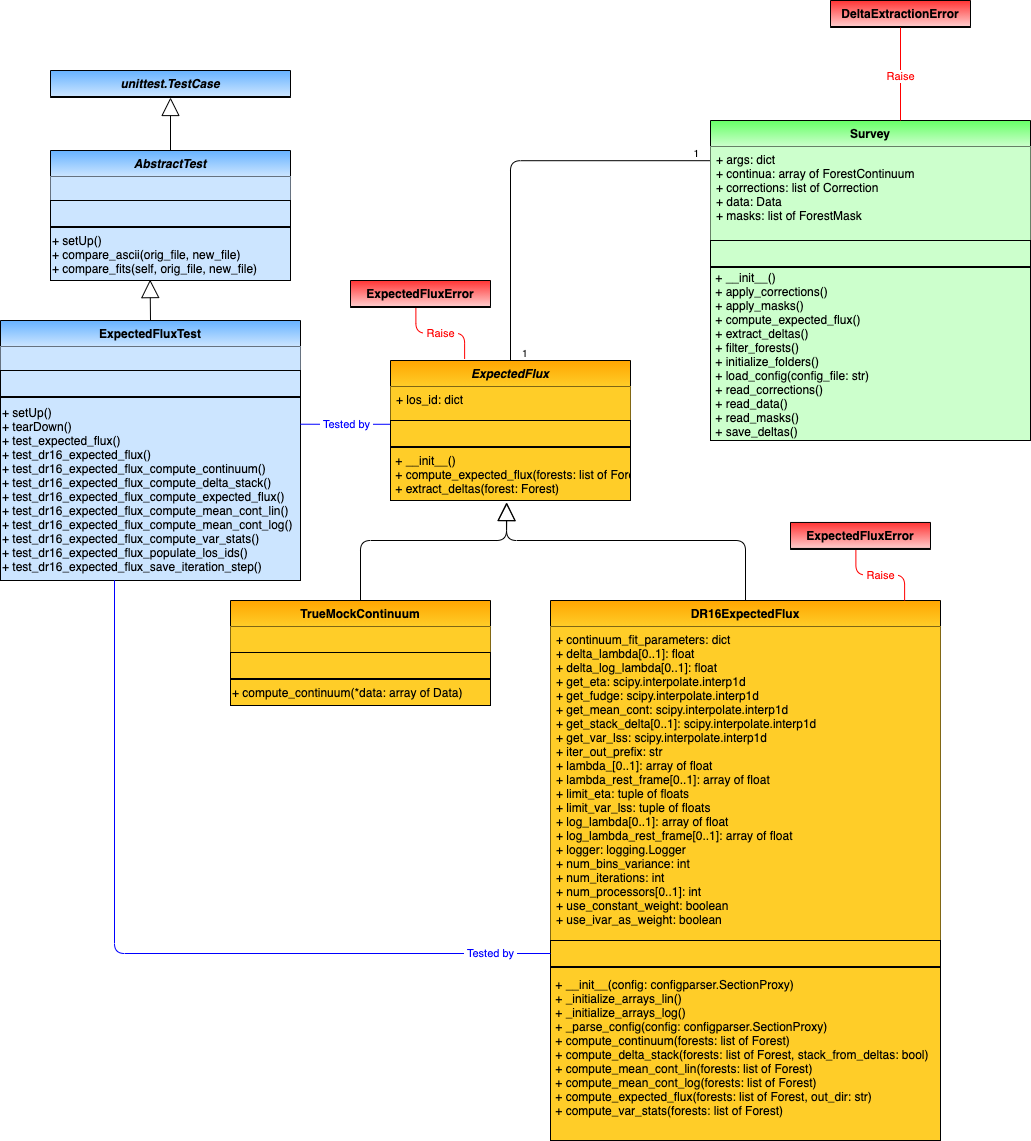

In [5]:
from IPython.display import Image
Image("../docs/data_model/data_model-ExpectedFlux.png")

And the Full Data Model to put things in context

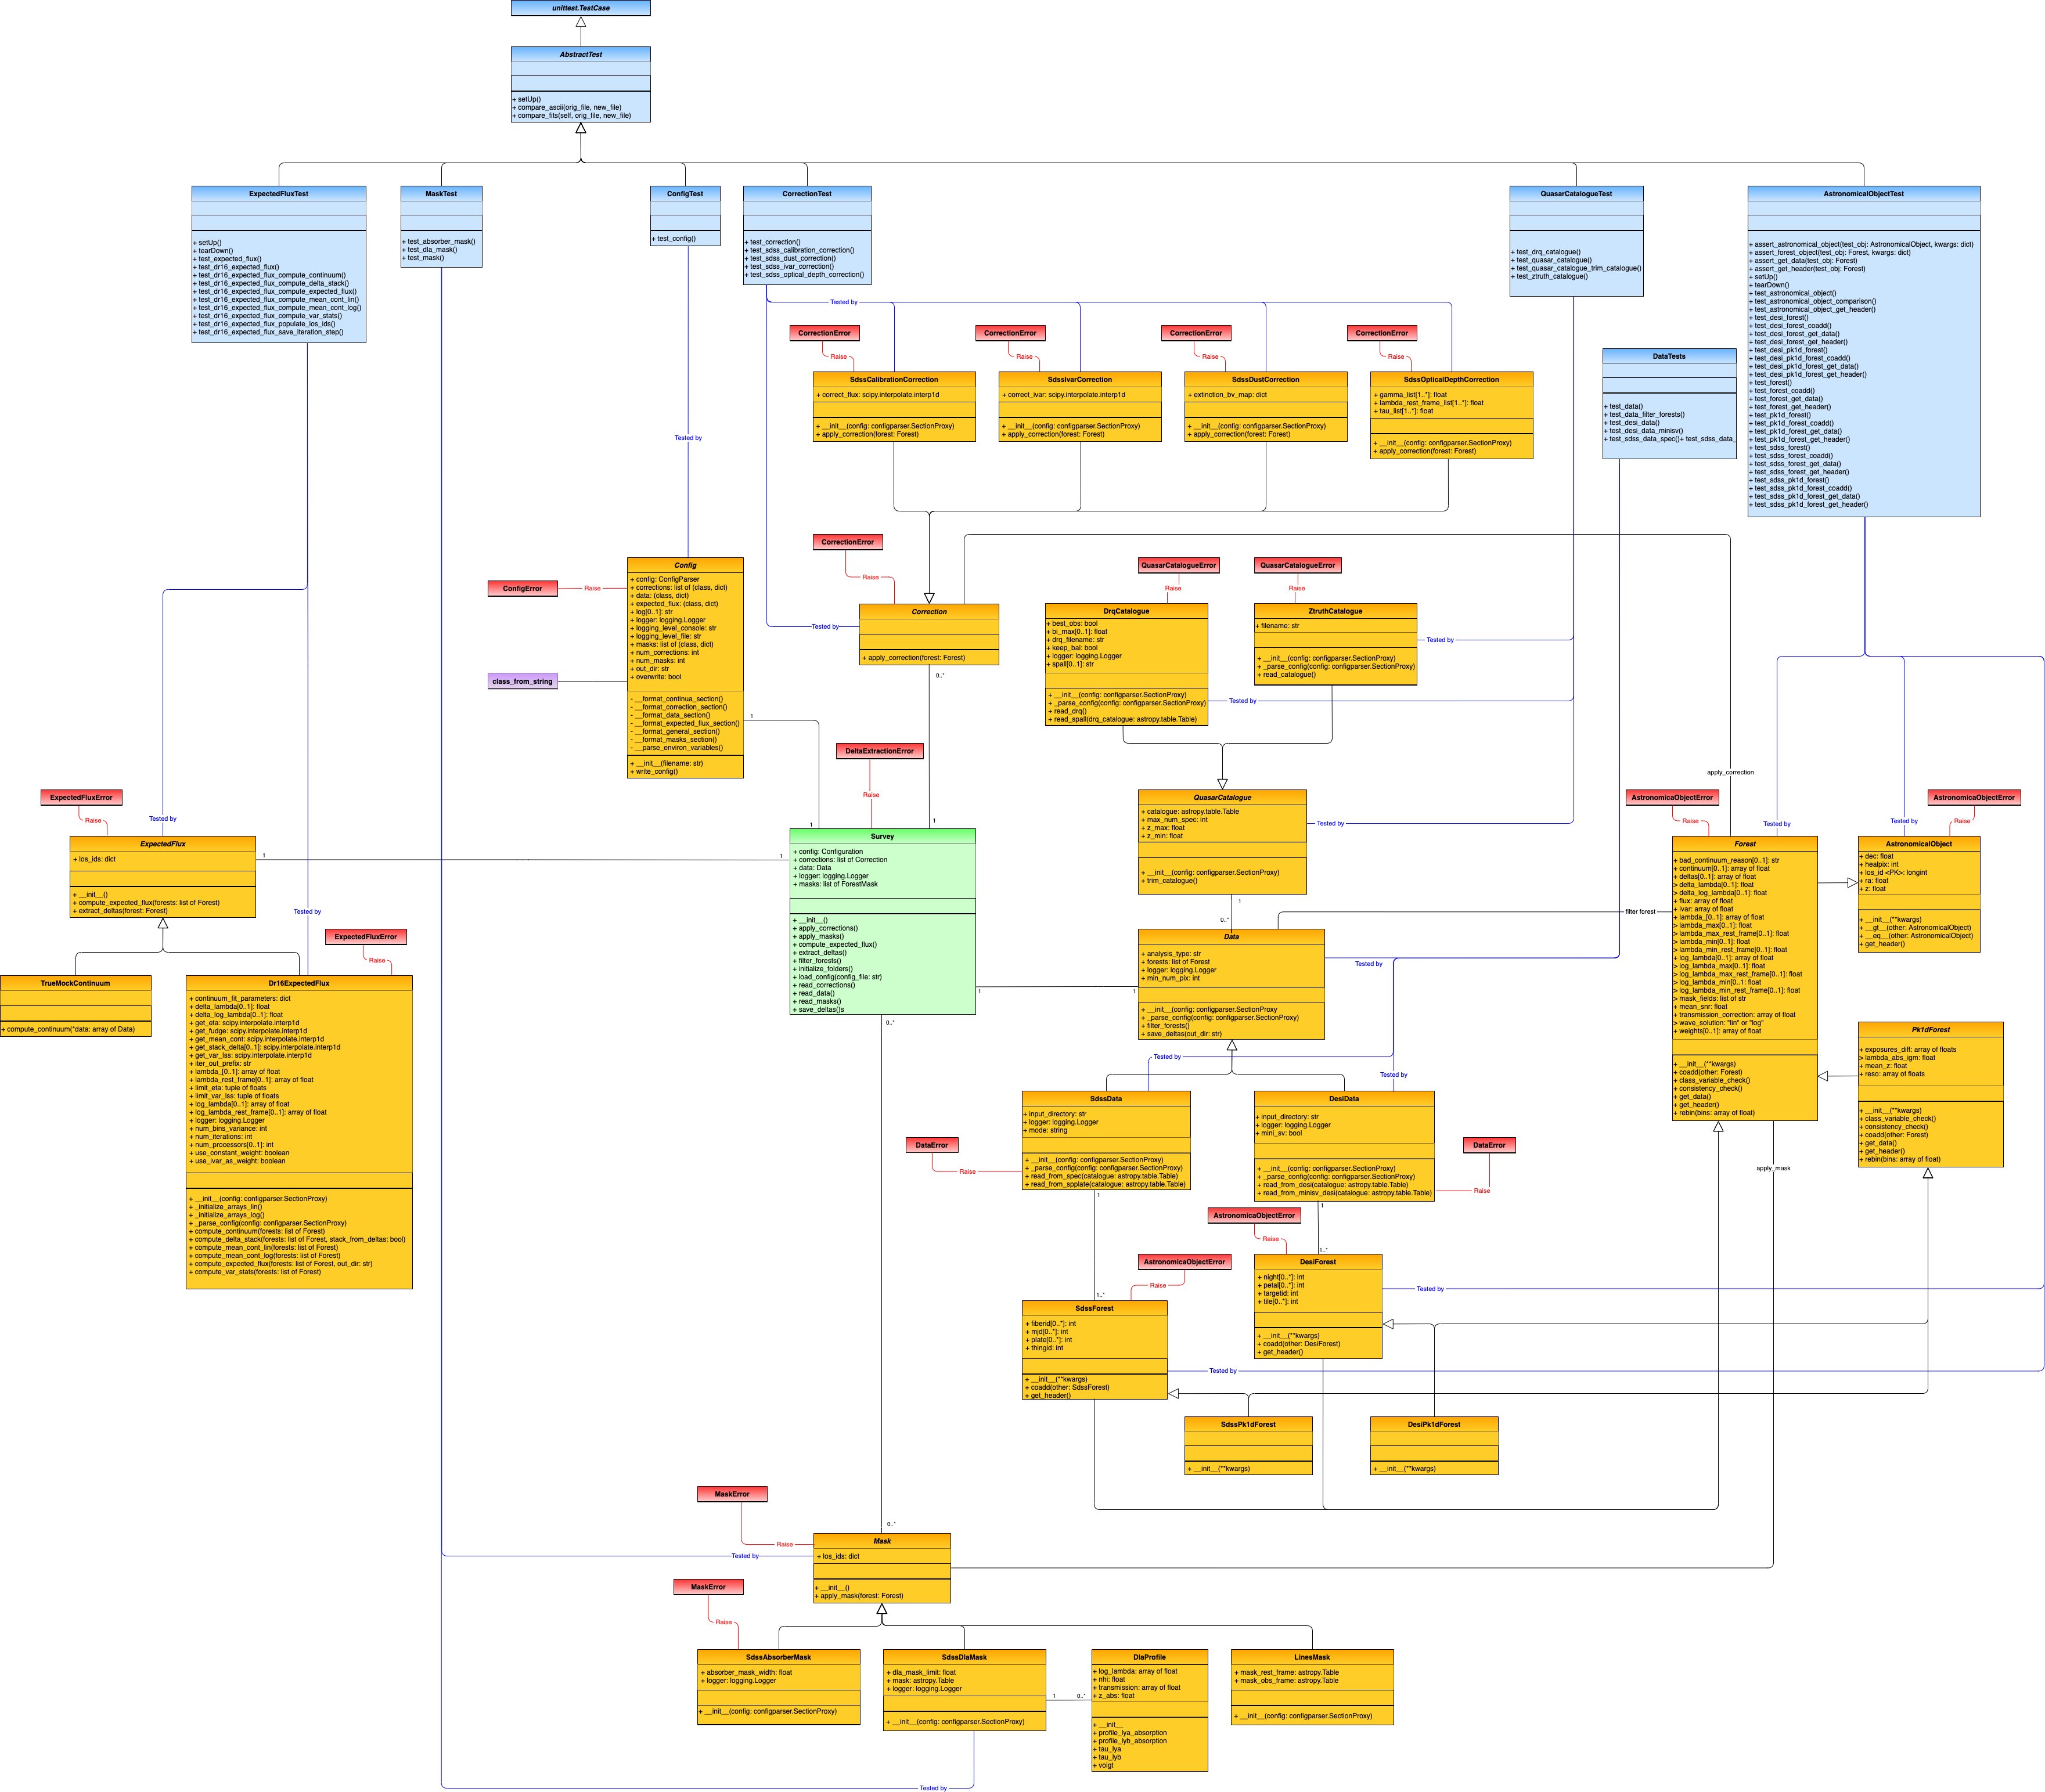

In [4]:
Image("../docs/data_model/data_model-FullDataModel.png")

# Check for similarities
Now that we know the data model, we can look for similarities. Are any of the existing expected fluxes similar? If only minor changes are required, it might be better to inherit from one of the already existing classes. Otherwise a new class will need to be added. The idea is that we have the least amount of repeated code.

Here are a couple of examples:

- Suppose we want to add a new ExpectedFlux that is essentially the same as the Dr16ExpectedFlux, except that we want to use more than one template as a function of redshift. Then we could have a parent class Dr16ExpectedFluxBase (that will inherit from ExpectedFlux) with the common bits of the code and two child classes  Dr16ExpectedFlux and Dr16ExpectedFluxMultipleTemplates with the different bits

- Suppose we want to add a new ExpectedFlux that uses only the red side of the spectra. In this case we would create a completely new class RedFitExpectedFlux that will inherit from ExpectedFlux

- Suppose that we want to add a new ExpectedFlx that is essentially the same as the Dr16ExpectedFlux but without using the fudge factor. In this case we will just modify the existing class


# Update the data model
Once we have an idea in mind, we need to update the data model. To do so, we go to https://app.diagrams.net/ and load the data model file from `py/picca/delta_extraction/docs/data_model/data_model.drawio`. Once the file it is loaded, we add the new classes to the diagrams. We need to modify the diagram under "ExpectedFlux", but also the "FullDataModel" diagram. Do not forget to modify the test classes accordingly!

Using the export tool, we update the plots in `py/picca/delta_extraction/docs/data_model/`. 

# Create the new class
Now it's time to create the new class. Remember that we need to define the functions `compute_expected_flux`. If we need to change the defalut way the deltas are extracted, then we will need to overload the function `extract_deltas` as well. Check the documentation of those functions in `py/picca/delta_extraction/expected_flux.py`. In general, the code will have this structure:

In [10]:
from picca.delta_extraction.expected_flux import ExpectedFlux

class MyNewExpectedFlux(ExpectedFlux):
    """This is my new expected flux
    
    Methods
    -------
    extract_deltas (from ExpectedFlux)
    compute_expected_flux
    __init__
    
    Attributes
    ----------
    los_ids: dict (from ExpectedFlux)
    A dictionary to store the mean expected flux fraction, the weights, and
    the inverse variance for each line of sight. Keys are the identifier for the
    line of sight and values are dictionaries with the keys "mean expected flux",
    and "weights" pointing to the respective arrays. If the given Forests are
    also Pk1dForests, then the key "ivar" must be available. Arrays have the same
    size as the flux array for the corresponding line of sight forest instance.

    """
    def __init__(self, config):
        """Initializes class instance.

        Arguments
        ---------
        config: configparser.SectionProxy
        Parsed options to initialize class
        """
        # initialize parent class
        super().__init__()
        
        # initialize class
        pass
    
    def compute_expected_flux(self, forest):
        """Compute the mean expected flux of the forests.
        This includes the quasar continua and the mean transimission. It is
        computed iteratively following as explained in du Mas des Bourboux et
        al. (2020)

        Arguments
        ---------
        forests: List of Forest
        A list of Forest from which to compute the deltas.

        out_dir: str
        Directory where expected flux information will be saved

        Raise
        -----
        MeanExpectedFluxError if function was not overloaded by child class
        """
        # does something to compute the expected flux
        # maybe raise some errors if, for example, a linear wavelength solution is required, but 
        # it is intead a logarithmic wavelength solution
        pass

Alternatively, if we are just slightly modifying an existing correction, we can inherit from it:

In [11]:
from picca.delta_extraction.expected_flux import ExpectedFlux

class MyOtherNewExpectedFlux(MyNewExpectedFlux):
    """This is my other new expected flux that inherits from MyNewExpectedFlux
    
    Methods
    -------
    extract_deltas (from ExpectedFlux)
    compute_expected_flux (from MyNewExpectedFlux)
    __init__
    
    Attributes
    ----------
    los_ids: dict (from ExpectedFlux)
    A dictionary to store the mean expected flux fraction, the weights, and
    the inverse variance for each line of sight. Keys are the identifier for the
    line of sight and values are dictionaries with the keys "mean expected flux",
    and "weights" pointing to the respective arrays. If the given Forests are
    also Pk1dForests, then the key "ivar" must be available. Arrays have the same
    size as the flux array for the corresponding line of sight forest instance.
    """
    def __init__(self, config):
        """Initializes class instance.

        Arguments
        ---------
        config: configparser.SectionProxy
        Parsed options to initialize class
        """
        # initialize parent class
        super().__init__()
        
        # initialize class
        pass
    
    # here we do not need to define the method compute_expected_flux since we are retrieving it 
    # from MyNewExpectedFlux

The code should be saved in a file called `my_new_expected_flux.py` (for `MyNewExpectedFlux`) or `my_other_new_expected_flux.py` (for `MyOtherNewExpectedFlux`) which should be placed under `py/picca/delta_extraction/expected_fluxes/`. This way the configuration parser will be able to find it without us having to specify the module path

# Add tests
Once we have created our class, we need to add some tests that show that the class is working properly. This way, if we need to do some updates, we will know it still works as intended. Tests for expected fluxes are run from `expected_flux_tests.py`. What we need to do is to add one or more methods. Note that they need to start with 'test': 

In [8]:
def test_my_new_expected_flux(self):
    """Test MyNewExpectedFlux"""
    pass

def test_my_new_expected_flux_specific_function(self):
    """Test a specific function or method used by MyNewExpectedFlux"""
    pass

If possible, it would be nice to keep the functions in alphabetical ordering so that we can quickly find them later on

# Update configuration tutorial
Now that we are sure it works, we need to update the [expected flux] section of the configuration tutorial to explain the arguments (required or not) used in the new expected flux. This usually includes some input filenames and/or some flags

# Add workflow diagrams
If the correction is simple, we are already finished. However, if the Correction interacts with other classes or functions, or has a number methods, it will be useful to draw a workflow diagram. This diagram can help other people (including your future self) understand what is happening and where are things happening. This is useful not only for debugging, but also to add possible extensions to the expected flux.

To create a workflow diagram go to https://app.diagrams.net/ and load the workflow diagrams file from `py/picca/delta_extraction/docs/workflow/workflow.drawio`. Once the file it is loaded, we add the new workflow to the diagrams. 

Using the export tool, we update the plots in `py/picca/delta_extraction/docs/workflow/`. 

Congratulations you are done!! Now you should do a Pull Request on GitHub